
# Global Payments, FX & Customer Risk Analytics
## Fintech Analytics Case Study

This notebook simulates a cross-border payments platform and answers **45 structured analytical questions**
covering:

1. Data Profiling & Cleaning  
2. Transaction & Revenue Analytics  
3. Customer & Risk Segmentation  
4. FX & Financial Modeling  
5. Strategic Business Insights  

All data is generated internally.


## 1️⃣ Import Libraries

In [1]:

import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

np.random.seed(42)
plt.style.use("default")


## 2️⃣ Data Generation (Simulated Environment)

In [2]:

# Customers
customers = pd.DataFrame({
    "customer_id": range(1, 501),
    "country": np.random.choice(["India","UK","USA","Singapore","UAE"], 500),
    "customer_type": np.random.choice(["Individual","Business"], 500, p=[0.7,0.3]),
    "signup_date": pd.to_datetime("2023-01-01") +
                   pd.to_timedelta(np.random.randint(0,365,500), unit="D"),
    "kyc_status": np.random.choice(["Verified","Pending"], 500, p=[0.85,0.15]),
    "risk_score": np.random.randint(10,95,500)
})

# Inject issues
customers.loc[np.random.choice(customers.index,15), "kyc_status"] = np.nan

# Transactions
transactions = pd.DataFrame({
    "transaction_id": range(10001,13001),
    "customer_id": np.random.choice(customers["customer_id"],3000),
    "transaction_date": pd.to_datetime("2024-01-01") +
                        pd.to_timedelta(np.random.randint(0,180,3000), unit="D"),
    "amount_usd": np.round(np.random.exponential(scale=200,size=3000),2),
    "currency": np.random.choice(["INR","GBP","USD","SGD","AED"],3000),
    "payment_type": np.random.choice(["Card","Bank Transfer","Wallet"],3000),
    "transaction_status": np.random.choice(["Success","Failed"],3000,p=[0.92,0.08]),
    "fx_applied": np.random.choice(["Yes","No"],3000,p=[0.75,0.25])
})

transactions.loc[np.random.choice(transactions.index,20), "amount_usd"] = -1
transactions.loc[np.random.choice(transactions.index,30), "payment_type"] = "card "
transactions = pd.concat([transactions, transactions.sample(25)], ignore_index=True)

# FX
fx_rates = pd.DataFrame({
    "date": pd.date_range("2024-01-01", periods=180),
    "currency": np.random.choice(["INR","GBP","SGD","AED"],180),
    "fx_rate_to_usd": np.round(np.random.uniform(0.012,1.4,180),4),
    "fx_margin_pct": np.round(np.random.uniform(0.2,2.5,180),2)
})

fx_rates.loc[np.random.choice(fx_rates.index,12), "fx_margin_pct"] = np.nan


In [5]:
customers.head()


,customer_id,country,customer_type,signup_date,kyc_status,risk_score
0,1,Singapore,Individual,2023-02-05,Verified,41
1,2,UAE,Business,2023-10-12,Verified,45
2,3,USA,Individual,2023-07-07,Verified,90
3,4,UAE,Business,2023-03-23,Verified,69
4,5,UAE,Individual,2023-01-02,Verified,20


In [6]:
transactions.head()


,transaction_id,customer_id,transaction_date,amount_usd,currency,payment_type,transaction_status,fx_applied
0,10001,286,2024-06-13,25.65,AED,Bank Transfer,Success,Yes
1,10002,474,2024-02-23,173.87,SGD,Wallet,Success,Yes
2,10003,496,2024-06-25,528.35,USD,Wallet,Success,Yes
3,10004,277,2024-04-24,137.33,AED,Wallet,Success,Yes
4,10005,156,2024-05-18,370.23,GBP,Wallet,Success,Yes


In [7]:
fx_rates.head()

,date,currency,fx_rate_to_usd,fx_margin_pct
0,2024-01-01,GBP,0.7020,0.35
1,2024-01-02,AED,0.3161,0.88
2,2024-01-03,SGD,1.3778,0.94
3,2024-01-04,GBP,1.1880,1.40
4,2024-01-05,INR,0.0484,1.72


## 3️⃣ Data Modeling & Cleaning

In [8]:
# Dataset Overview
customers.info()
print("\n" + "="*50 + "\n")
transactions.info()
print("\n" + "="*50 + "\n")
fx_rates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   customer_id    500 non-null    int64         
 1   country        500 non-null    object        
 2   customer_type  500 non-null    object        
 3   signup_date    500 non-null    datetime64[ns]
 4   kyc_status     486 non-null    object        
 5   risk_score     500 non-null    int32         
dtypes: datetime64[ns](1), int32(1), int64(1), object(3)
memory usage: 21.6+ KB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3025 entries, 0 to 3024
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   transaction_id      3025 non-null   int64         
 1   customer_id         3025 non-null   int64         
 2   transaction_date    3025 non-null   datetime64[ns]
 3   amount_usd     

In [9]:
print("Customers null values:")
print(customers.isnull().sum())
print("\nTransactions null values:")
print(transactions.isnull().sum())
print("\nFX Rates null values:")
print(fx_rates.isnull().sum())

Customers null values:
customer_id       0
country           0
customer_type     0
signup_date       0
kyc_status       14
risk_score        0
dtype: int64

Transactions null values:
transaction_id        0
customer_id           0
transaction_date      0
amount_usd            0
currency              0
payment_type          0
transaction_status    0
fx_applied            0
dtype: int64

FX Rates null values:
date               0
currency           0
fx_rate_to_usd     0
fx_margin_pct     12
dtype: int64


In [13]:
print("Customers null values:")
print((customers.isnull().mean()*100).sort_values(ascending=False))
print("\nTransactions null values:")
print((transactions.isnull().mean()*100).sort_values(ascending=False))
print("\nFX Rates null values:")
print((fx_rates.isnull().mean()*100).sort_values(ascending=False))

Customers null values:
kyc_status       2.8
customer_id      0.0
country          0.0
customer_type    0.0
signup_date      0.0
risk_score       0.0
dtype: float64

Transactions null values:
transaction_id        0.0
customer_id           0.0
transaction_date      0.0
amount_usd            0.0
currency              0.0
payment_type          0.0
transaction_status    0.0
fx_applied            0.0
dtype: float64

FX Rates null values:
fx_margin_pct     6.666667
date              0.000000
currency          0.000000
fx_rate_to_usd    0.000000
dtype: float64


In [14]:
# Find Duplicate Records
print("Customers duplicate rows:", customers.duplicated().sum()) # Check for duplicate rows in customers dataset
print("Transactions duplicate rows:", transactions.duplicated().sum()) # Check for duplicate rows in transactions dataset
print("FX Rates duplicate rows:", fx_rates.duplicated().sum()) # Check for duplicate rows in FX rates dataset

Customers duplicate rows: 0
Transactions duplicate rows: 25
FX Rates duplicate rows: 0


In [ ]:
# finding duplicate records where each column has the same value as another row, which indicates exact duplicates. This is important to identify and handle to ensure data quality and accuracy in analysis.
customers[customers.duplicated()] 

,customer_id,country,customer_type,signup_date,kyc_status,risk_score


In [18]:
#finding duplicate using the primary key, which is the unique identifier for each record. 
# In this case, we check for duplicate customer_id values to identify if there are multiple records for the same customer.
customers[customers.duplicated(subset=["customer_id"], keep=False)].sort_values("customer_id")

,customer_id,country,customer_type,signup_date,kyc_status,risk_score


In [19]:
fx_rates[fx_rates.duplicated(subset=["date","currency"], keep=False)].sort_values(["date","currency"])


,date,currency,fx_rate_to_usd,fx_margin_pct


In [ ]:
transactions[transactions.duplicated(subset=["transaction_id"], keep=False)].sort_values("transaction_id")
# keep false will mark all duplicates as True, so we can see all occurrences of the duplicate transaction_id, which helps us identify 
# if there are multiple records for the same transaction.

,transaction_id,customer_id,transaction_date,amount_usd,currency,payment_type,transaction_status,fx_applied
69,10070,142,2024-04-14,133.06,INR,Wallet,Success,Yes
3013,10070,142,2024-04-14,133.06,INR,Wallet,Success,Yes
3021,10310,59,2024-01-14,309.03,AED,Bank Transfer,Success,No
309,10310,59,2024-01-14,309.03,AED,Bank Transfer,Success,No
489,10490,126,2024-03-28,117.08,USD,Card,Success,Yes
3008,10490,126,2024-03-28,117.08,USD,Card,Success,Yes
3020,10646,70,2024-05-12,231.73,AED,Wallet,Success,Yes
645,10646,70,2024-05-12,231.73,AED,Wallet,Success,Yes
716,10717,54,2024-06-02,521.26,GBP,Bank Transfer,Success,Yes
3022,10717,54,2024-06-02,521.26,GBP,Bank Transfer,Success,Yes


In [ ]:
# getting the count of duplicate transaction_id values to see how many times each duplicate occurs

#method 1
count = transactions["transaction_id"].value_counts().reset_index(name="records")
count[count["records"] > 1].sort_values("records", ascending=False).shape[0]

#method 2
transactions["transaction_id"].value_counts().loc[lambda x: x > 1] # Check for duplicate transaction IDs after removal

#method 3
txn_counts = transactions.groupby("transaction_id").size()
txn_counts[txn_counts > 1].shape[0]

25

In [ ]:
print(transactions.shape)  # this has duplicate records, so the number of rows is greater than the number of unique transaction_id values
print(customers.shape)
print(fx_rates.shape)

(3025, 8)
(500, 6)
(180, 4)


In [36]:
customers.drop_duplicates(subset="customer_id", inplace=True) # Remove duplicate customer records based on customer_id
transactions.drop_duplicates(subset="transaction_id",inplace=True) # Remove duplicate transaction records
fx_rates.drop_duplicates(inplace=True) # Remove duplicate FX rate records

In [37]:
print(transactions.shape)  # check again after removing duplicates
print(customers.shape)
print(fx_rates.shape)

(3000, 8)
(500, 6)
(180, 4)


In [38]:
transactions["currency"].unique() # Check unique values in currency column to identify any dirty categorical values

array(['AED', 'SGD', 'USD', 'GBP', 'INR'], dtype=object)

In [ ]:
fx_rates["currency"].unique() # Check unique values in currency column to identify any dirty categorical values

# as you can see USD is present in transactions but not in fx_rates, which indicates that there may be some transactions that do not have corresponding FX rates, 
# which could lead to issues when trying to convert amounts to USD for analysis.

array(['GBP', 'AED', 'SGD', 'INR'], dtype=object)

In [40]:
# merging datasets to create a unified view for analysis. We perform left joins to ensure that we keep all transactions and enrich them with customer and FX rate information where available.
df = transactions.merge(customers,on="customer_id",how="left")
df = df.merge(fx_rates,left_on=["transaction_date","currency"],
              right_on=["date","currency"],how="left")



In [41]:
df.head()

,transaction_id,customer_id,transaction_date,amount_usd,currency,payment_type,transaction_status,fx_applied,country,customer_type,signup_date,kyc_status,risk_score,date,fx_rate_to_usd,fx_margin_pct
0,10001,286,2024-06-13,25.65,AED,Bank Transfer,Success,Yes,UAE,Individual,2023-08-29,Verified,46,2024-06-13,0.4478,1.1
1,10002,474,2024-02-23,173.87,SGD,Wallet,Success,Yes,UAE,Individual,2023-01-27,Verified,55,NaT,NaN,NaN
2,10003,496,2024-06-25,528.35,USD,Wallet,Success,Yes,India,Business,2023-08-24,Verified,18,NaT,NaN,NaN
3,10004,277,2024-04-24,137.33,AED,Wallet,Success,Yes,UAE,Business,2023-01-05,Verified,90,NaT,NaN,NaN
4,10005,156,2024-05-18,370.23,GBP,Wallet,Success,Yes,India,Individual,2023-03-22,Verified,70,2024-05-18,1.2865,NaN


In [ ]:
# Check the distribution of currencies in FX rates dataset to understand coverage and identify any gaps
# fx_rates does not have USD records, so all transactions in USD will have missing FX rates.

fx_rates["currency"].value_counts().reset_index().rename(columns={"index": "currency", "currency": "count"}) 

,count,count
0,AED,48
1,GBP,45
2,INR,44
3,SGD,43


In [43]:
# check how many records have fx_rate_to_usd as null, which indicates transactions that do not have corresponding FX rates, 
# likely due to the presence of USD transactions that are not covered in the FX rates dataset.
null_fx_count = df[df["fx_rate_to_usd"].isnull()].shape[0]
print(f"Number of transactions with null FX rates: {null_fx_count}")

Number of transactions with null FX rates: 2409


In [44]:
# understand about the amount_usd column, which is the transaction amount in USD. We want to check for any negative values, 
# which are not valid for transaction amounts and could indicate data quality issues.

df['amount_usd'].describe(percentiles=[0.25, 0.5, 0.75])

count    3000.000000
mean      189.910597
std       190.832293
min        -1.000000
25%        53.382500
50%       130.850000
75%       262.450000
max      1505.040000
Name: amount_usd, dtype: float64

In [46]:
# replce -1 with 0, because -1 is not a valid transaction amount and likely represents missing or erroneous data.
# also for analysis as USD is not present in FX rates, so we cannot convert it to USD, but we can set it to 0 for analysis as USD

df.loc[df['amount_usd'] < 0, 'amount_usd'] = 0
df.loc[df["currency"] == "USD", "fx_rate_to_usd"] = 1.0
df.loc[df["currency"] == "USD", "fx_margin_pct"] = 0.0

In [47]:
# Now check the amount_usd column again to confirm that all negative values have been replaced with 0, and that USD transactions have appropriate FX rates 
# and margins set for analysis.
df['amount_usd'].describe(percentiles=[0.25, 0.5, 0.75])

count    3000.000000
mean      189.917263
std       190.825639
min         0.000000
25%        53.382500
50%       130.850000
75%       262.450000
max      1505.040000
Name: amount_usd, dtype: float64

In [48]:
null_fx_count = df[df["fx_rate_to_usd"].isnull()].shape[0]
print(f"Number of transactions with null FX rates: {null_fx_count}")

Number of transactions with null FX rates: 1840


In [49]:
df = df.drop_duplicates() # Remove any remaining duplicate records that may exist after merging, ensuring that each transaction is represented only once in the dataset.
# its by default set to keep the first occurrence of the duplicate and drop the rest, which is appropriate in this context as we want to retain one record for # each unique transaction.
df = df[df["amount_usd"] > 0] # Remove transactions with non-positive amounts, as they may indicate refunds, errors, or test transactions that could skew analysis.

df["payment_type"] = df["payment_type"].str.strip().str.title()

df["kyc_status"] = df["kyc_status"].fillna("Pending")

df["fx_margin_pct"] = df.groupby("currency")["fx_margin_pct"].transform(lambda x: x.fillna(x.median())) # Fill missing FX margin percentages with the median margin for each 
# currency, which helps to maintain consistency in analysis while handling missing values in a way that is less sensitive to outliers than mean imputation.

df["transaction_date"] = df["transaction_date"].dt.normalize() # Normalize transaction_date to remove time component, if any, for consistent date-based analysis

df["date"]=df["date"].dt.normalize() # Normalize date in fx_rates to ensure it matches the normalized transaction_date for accurate merging and analysis


In [50]:
df.shape

(2980, 16)

## 4️⃣ Feature Engineering

In [51]:

df["is_success"] = np.where(df["transaction_status"]=="Success",1,0)
df["month"] = df["transaction_date"].dt.to_period("M")
df["customer_age_days"] = (df["transaction_date"] - df["signup_date"]).dt.days
df["fx_revenue"] = np.where(df["fx_applied"]=="Yes",
                            df["amount_usd"]*(df["fx_margin_pct"]/100),0)
df["risk_bucket"] = pd.qcut(df["risk_score"],q=4,
                            labels=["Low","Medium","High","Very High"])


In [52]:
df.isna().sum()

transaction_id           0
customer_id              0
transaction_date         0
amount_usd               0
currency                 0
payment_type             0
transaction_status       0
fx_applied               0
country                  0
customer_type            0
signup_date              0
kyc_status               0
risk_score               0
date                  2392
fx_rate_to_usd        1828
fx_margin_pct            0
is_success               0
month                    0
customer_age_days        0
fx_revenue               0
risk_bucket              0
dtype: int64

In [53]:
df["kyc_status"].value_counts(dropna=False) # Check distribution of KYC status including missing values

kyc_status
Verified    2566
Pending      414
Name: count, dtype: int64

In [54]:
df["amount_usd"].describe()


count    2980.000000
mean      191.191876
std       190.827465
min         0.050000
25%        54.710000
50%       131.735000
75%       263.600000
max      1505.040000
Name: amount_usd, dtype: float64

In [55]:
data_quality = pd.DataFrame({
    "missing_%": df.isnull().mean() * 100,
    "unique_values": df.nunique(),
    "dtype": df.dtypes
})

data_quality

,missing_%,unique_values,dtype
transaction_id,0.000000,2980,int64
customer_id,0.000000,499,int64
transaction_date,0.000000,180,datetime64[ns]
amount_usd,0.000000,2883,float64
currency,0.000000,5,object
payment_type,0.000000,3,object
transaction_status,0.000000,2,object
fx_applied,0.000000,2,object
country,0.000000,5,object
customer_type,0.000000,2,object


# 5️⃣ 45 Analytical Questions

In [ ]:
# Q1 Total Number of Customers made a transaction
df['customer_id'].nunique()

499

In [ ]:
# Q2️ What is the transaction date range?
(df["transaction_date"].min(), df["transaction_date"].max())

(Timestamp('2024-01-01 00:00:00'), Timestamp('2024-06-28 00:00:00'))

In [58]:
# Q3 % of Verified vs Pending KYC Customers
df["kyc_status"].value_counts(normalize=True)*100

kyc_status
Verified    86.107383
Pending     13.892617
Name: proportion, dtype: float64

<Axes: xlabel='kyc_status'>

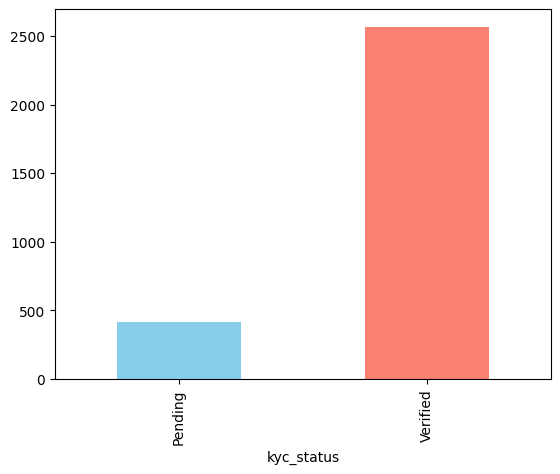

In [60]:
kyc_counts = df.groupby("kyc_status").size()

kyc_counts.plot(kind="bar", color=["skyblue","salmon"])

In [ ]:
# Q4 Number of failed transactions

failed_txn_count = df[df["transaction_status"] == "Failed"].shape[0]
failed_txn_count

(df["transaction_status"] == "Failed").sum()

np.int64(240)

In [ ]:
# Q5 Transactions missing FX data (post-join)

df.isnull().mean().sort_values(ascending=False) * 100

date                  80.268456
fx_rate_to_usd        61.342282
transaction_date       0.000000
customer_id            0.000000
transaction_id         0.000000
currency               0.000000
amount_usd             0.000000
payment_type           0.000000
transaction_status     0.000000
customer_type          0.000000
signup_date            0.000000
fx_applied             0.000000
country                0.000000
risk_score             0.000000
kyc_status             0.000000
fx_margin_pct          0.000000
is_success             0.000000
month                  0.000000
customer_age_days      0.000000
fx_revenue             0.000000
risk_bucket            0.000000
dtype: float64

In [63]:
df["fx_margin_pct"].isnull().sum()

np.int64(0)

In [ ]:
# Q6 Duplicate detection & handling

df.duplicated(subset="transaction_id").sum()

np.int64(0)

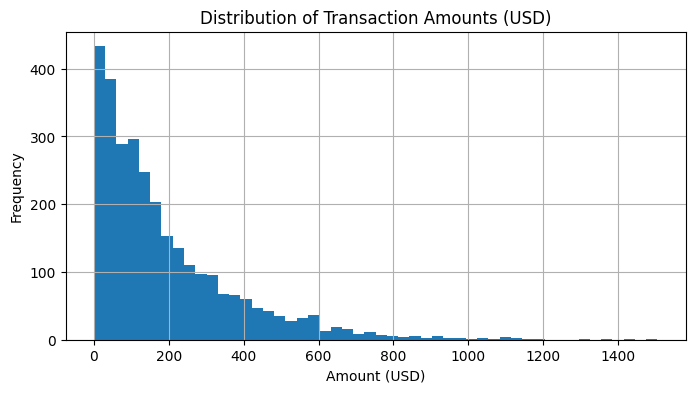

In [65]:
# Q7 What is the distribution of transaction amounts?

df['amount_usd'].hist(bins=50, figsize=(8,4))
plt.title("Distribution of Transaction Amounts (USD)")
plt.xlabel("Amount (USD)")
plt.ylabel("Frequency")
plt.show()

150


Text(0.5, 1.0, 'Boxplot of Transaction Amounts (USD) with Outliers')

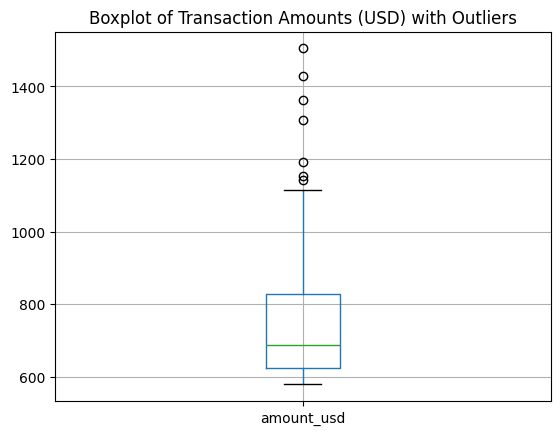

In [68]:
# Q8️ Outlier detection using IQR (numpy)

Q1 = df["amount_usd"].quantile(0.25)
Q3 = df["amount_usd"].quantile(0.75)
IQR = Q3 - Q1

outliers = df[
    (df["amount_usd"] < Q1 - 1.5 * IQR) |
    (df["amount_usd"] > Q3 + 1.5 * IQR)
]

print(len(outliers))

outliers.boxplot(column="amount_usd")
plt.title("Boxplot of Transaction Amounts (USD) with Outliers")

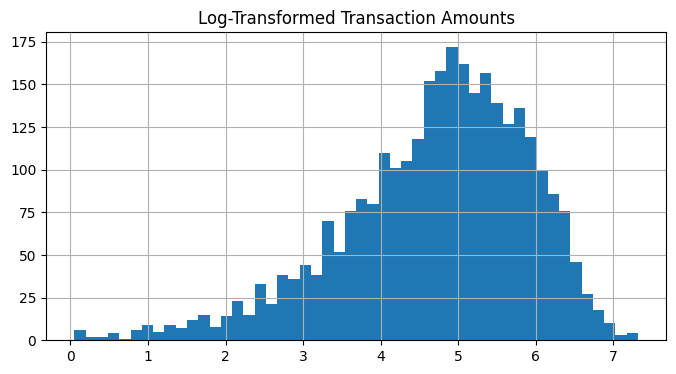

In [69]:
# Q9️ Skewness correction (log transform)

df["log_amount_usd"] = np.log1p(df["amount_usd"]) # log1p is used to handle zero values without resulting in -inf

df["log_amount_usd"].hist(bins=50, figsize=(8,4))
plt.title("Log-Transformed Transaction Amounts")
plt.show()

In [70]:
# Q10 Final Data Quality Summary

data_quality = pd.DataFrame({
    "missing_%": df.isnull().mean() * 100,
    "unique_values": df.nunique(),
    "dtype": df.dtypes
})

data_quality

,missing_%,unique_values,dtype
transaction_id,0.000000,2980,int64
customer_id,0.000000,499,int64
transaction_date,0.000000,180,datetime64[ns]
amount_usd,0.000000,2883,float64
currency,0.000000,5,object
payment_type,0.000000,3,object
transaction_status,0.000000,2,object
fx_applied,0.000000,2,object
country,0.000000,5,object
customer_type,0.000000,2,object


In [71]:
# Q11️ Total transaction volume (USD)

df['amount_usd'].sum()

print("Total Transaction Volume (USD):", df['amount_usd'].sum())

Total Transaction Volume (USD): 569751.79


In [72]:
# Q12️ Average vs median transaction value

print("Average transaction value (USD):", df['amount_usd'].mean())
print("Median transaction value (USD):", df['amount_usd'].median())

Average transaction value (USD): 191.1918758389262
Median transaction value (USD): 131.735


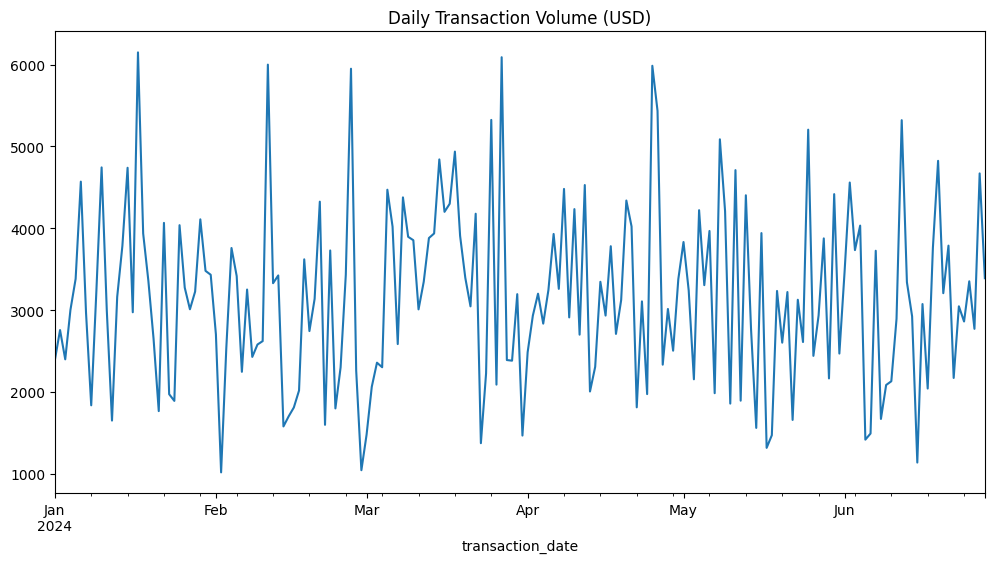

In [73]:
# Q13️ Daily transaction volume trend

df.groupby("transaction_date")["amount_usd"].sum().plot(figsize=(12,6))
plt.title("Daily Transaction Volume (USD)")
plt.show()

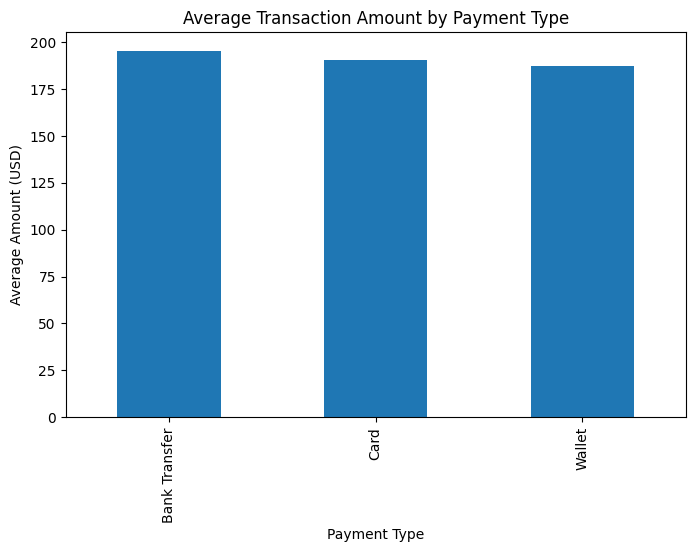

In [74]:
# Q14️ Average transaction size by payment type

df.groupby("payment_type")["amount_usd"].mean().plot(kind="bar", figsize=(8,5))
plt.title("Average Transaction Amount by Payment Type")
plt.xlabel("Payment Type")
plt.ylabel("Average Amount (USD)")
plt.show()

In [75]:
# Q15️ Success rate by payment type

df.groupby("payment_type")["is_success"].mean() * 100

payment_type
Bank Transfer    91.065990
Card             93.413174
Wallet           91.339376
Name: is_success, dtype: float64

In [ ]:
# Q16️ Top 10 customers by transaction value

df.groupby("customer_id")["amount_usd"].sum().sort_values(ascending=False).head(10)

customer_id
318    4024.49
59     3759.95
268    3696.58
222    3674.86
451    3451.11
434    3406.73
313    3379.52
414    3342.20
471    3258.28
48     3036.46
Name: amount_usd, dtype: float64

In [77]:
# Q17️ Business vs Individual contribution (%)

df.groupby("customer_type")["amount_usd"].sum() / df["amount_usd"].sum() * 100

customer_type
Business      27.476326
Individual    72.523674
Name: amount_usd, dtype: float64

In [78]:
# Q18️ Revenue by country

df.groupby("country")["amount_usd"].sum().sort_values(ascending=False)

country
Singapore    121704.83
India        121441.42
UK           114653.41
USA          106976.32
UAE          104975.81
Name: amount_usd, dtype: float64

In [79]:
# Q19️ Month-over-month revenue growth

df.groupby("month")["amount_usd"].sum().pct_change() * 100

month
2024-01          NaN
2024-02   -18.420871
2024-03    27.405182
2024-04    -5.785032
2024-05    -3.004885
2024-06    -9.382955
Freq: M, Name: amount_usd, dtype: float64

In [80]:
daily_volume = (
    df.groupby("transaction_date")["amount_usd"]
      .sum()
      .sort_index()
)


daily_volume.head()

transaction_date
2024-01-01    2386.66
2024-01-02    2756.10
2024-01-03    2398.19
2024-01-04    3001.83
2024-01-05    3381.01
Name: amount_usd, dtype: float64

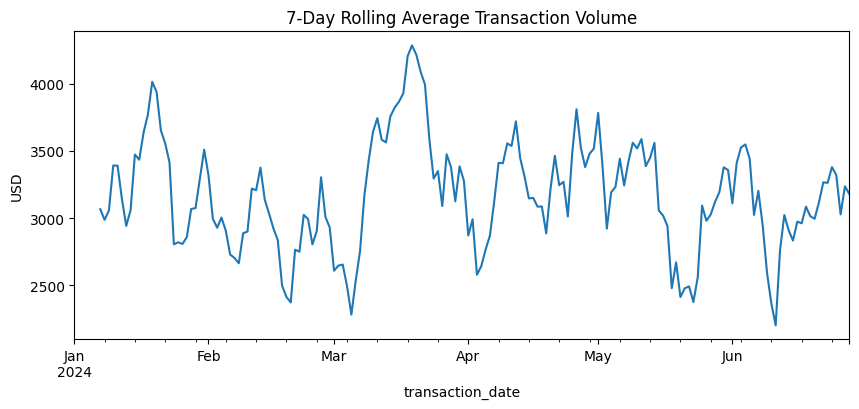

In [81]:
# Q20️ Rolling 7-day average revenue

rolling_7d = daily_volume.rolling(window=7).mean()

rolling_7d.plot(figsize=(10,4))
plt.title("7-Day Rolling Average Transaction Volume")
plt.ylabel("USD")
plt.show()


In [83]:
df["is_high_risk"] = np.where(df["risk_score"] >= 70, 1, 0)

In [84]:
# Q21️ How do high-risk vs low-risk customers differ in behavior?

df.groupby("is_high_risk")["amount_usd"].agg(txn_counts="count", avg_amount="mean", total_amount="sum")



,txn_counts,avg_amount,total_amount
is_high_risk,,,
0,2226,189.694155,422259.19
1,754,195.613528,147492.60


In [85]:
# Q22 What is the transaction failure rate by risk bucket?

df.groupby("risk_bucket")["is_success"].apply(  # apply functions to calculate failure rate by risk bucket
    lambda x: (1-x.mean()) * 100
).reset_index(name="failure_rate")  # x is the is_success column for each risk bucket group. x.mean() gives the success rate, so 1 - x.mean() gives the failure rate, and multiplying by 100 converts it to percentage.





C:\Users\zaids\AppData\Local\Temp\ipykernel_37820\2636470402.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("risk_bucket")["is_success"].apply(  # apply functions to calculate failure rate by risk bucket


,risk_bucket,failure_rate
0,Low,8.058124
1,Medium,7.352941
2,High,9.542484
3,Very High,7.183099


In [86]:
# Q23 How does KYC status impact transaction volume?
df.groupby("kyc_status").agg(
    customers=("customer_id", "nunique"),
    total_value=("amount_usd", "sum"),
    avg_value=("amount_usd", "mean")
)

,customers,total_value,avg_value
kyc_status,,,
Pending,71,82717.42,199.800531
Verified,428,487034.37,189.802950


In [ ]:
# Q24 Compare customer type behavior.

df.groupby("customer_type").agg(
    customers=("customer_id", "nunique"),
    total_value=("amount_usd", "sum"),
    avg_value=("amount_usd", "mean")

    # this is the modern syntax for renaming columns in an aggregation, where we specify the new column name followed by the aggregation function in a tuple.
)

,customers,total_value,avg_value
customer_type,,,
Business,143,156546.86,193.029420
Individual,356,413204.93,190.504809


In [ ]:
df.groupby("customer_type")["amount_usd"].agg(["sum", "mean", "count"]) 
#method 2

,sum,mean,count
customer_type,,,
Business,156546.86,193.029420,811
Individual,413204.93,190.504809,2169


In [ ]:
df.groupby("customer_type")["amount_usd"].agg(customers="nunique", total_value="sum", avg_value="mean")

#method 3

,customers,total_value,avg_value
customer_type,,,
Business,803,156546.86,193.029420
Individual,2114,413204.93,190.504809


In [93]:
# method 4
df.groupby("customer_type").agg({
    "customer_id": "nunique",
    "amount_usd": ["sum", "mean"],
    "risk_score": ["mean","median"]
})

customer_id amount_usd             risk_score       
                  nunique        sum        mean       mean median
customer_type                                                     
Business              143  156546.86  193.029420  50.295931   49.0
Individual            356  413204.93  190.504809  49.773628   48.0

In [ ]:
# Q26 Define new customers (≤30 days)

df["customer_segment"] = np.where(df["customer_age_days"] <= 30, "New", "Existing")

In [95]:
df.groupby("customer_segment").agg(
    customers=("customer_id", "nunique"),
    total_value=("amount_usd", "sum"),
    avg_value=("amount_usd", "mean")
)

,customers,total_value,avg_value
customer_segment,,,
Existing,497,564311.51,190.710210
New,15,5440.28,259.060952


In [96]:
# Q27️ Average transaction value per customer
avg_txn_per_cust = df.groupby("customer_id")["amount_usd"].mean()

avg_txn_per_cust.describe()

count    499.000000
mean     192.366950
std       88.134091
min       19.595000
25%      130.226429
50%      178.878750
75%      236.880000
max      739.740000
Name: amount_usd, dtype: float64

In [104]:
# Q28 Identify power users (top 10% by transaction volume).
customer_volume = df.groupby("customer_id")["amount_usd"].sum()
print(customer_volume.head(10))
top_10_percent = customer_volume.quantile(0.9)
print(f"Top 10% transaction volume threshold: {top_10_percent:.2f}") # 90% of values are below this threshold, so customers with transaction volume above this are considered power users.
power_users = customer_volume[customer_volume >= top_10_percent].index
power_users

customer_id
1     1872.87
2      351.65
3      876.46
4      603.91
5      887.45
6     1328.08
7     1168.86
8     2068.93
9      564.83
10     507.83
Name: amount_usd, dtype: float64
Top 10% transaction volume threshold: 2053.93


Index([  8,  16,  22,  47,  48,  49,  59,  62,  73,  84, 109, 114, 116, 127,
       132, 138, 156, 201, 207, 214, 222, 237, 245, 246, 250, 256, 264, 268,
       272, 273, 277, 307, 313, 318, 324, 338, 369, 390, 401, 403, 405, 414,
       424, 425, 434, 446, 451, 471, 480, 485],
      dtype='int64', name='customer_id')

In [105]:
df["is_power_user"]=df['customer_id'].isin(power_users) # Check how many customers are identified as power users based on the threshold

In [107]:
power_users_df = df[df["is_power_user"]]

power_users_df.head()

,transaction_id,customer_id,transaction_date,amount_usd,currency,payment_type,transaction_status,fx_applied,country,customer_type,...,fx_margin_pct,is_success,month,customer_age_days,fx_revenue,risk_bucket,log_amount_usd,is_high_risk,customer_segment,is_power_user
3,10004,277,2024-04-24,137.33,AED,Wallet,Success,Yes,UAE,Business,...,1.460,1,2024-04,475,2.005018,Very High,4.929642,1,Existing,True
4,10005,156,2024-05-18,370.23,GBP,Wallet,Success,Yes,India,Individual,...,1.545,1,2024-05,423,5.720053,High,5.916822,1,Existing,True
14,10015,307,2024-01-17,1115.84,AED,Bank Transfer,Success,Yes,India,Individual,...,1.320,1,2024-01,353,14.729088,Medium,7.018259,0,Existing,True
16,10017,338,2024-05-26,338.63,AED,Wallet,Success,No,Singapore,Individual,...,1.460,1,2024-05,456,0.000000,Low,5.827857,0,Existing,True
24,10025,273,2024-02-12,108.05,AED,Bank Transfer,Success,Yes,India,Individual,...,1.460,1,2024-02,190,1.577530,High,4.691806,0,Existing,True


In [109]:
# Q29 What % of total revenue comes from power users?


pct_rev_power_user = power_users_df['amount_usd'].sum() / df['amount_usd'].sum() * 100 # What % of total revenue comes from power users?

print(power_users_df['amount_usd'].sum())

print("Percentage of total revenue from power users: {:.2f}%".format(pct_rev_power_user))
print(f"Percentage of total revenue from power users: {pct_rev_power_user:.2f}%")

130390.10000000002
Percentage of total revenue from power users: 22.89%
Percentage of total revenue from power users: 22.89%


In [110]:
# Q30 How does customer country influence payment method preference?

country_payment_method = df.groupby(['country', 'payment_type'])['amount_usd'].sum().unstack(fill_value=0)
country_payment_method


payment_type,Bank Transfer,Card,Wallet
country,,,
India,42077.99,42050.16,37313.27
Singapore,40664.79,38198.34,42841.70
UAE,33493.59,38250.23,33231.99
UK,40442.15,37854.02,36357.24
USA,35954.27,34518.03,36504.02


In [111]:
# Q31 Calculate the percentage of each payment type used within each country to understand preferences.
country_payment_pct = (
    df.groupby(["country", "payment_type"])
      .size()
      .groupby(level=0)
      .transform(lambda x: 100 * x / x.sum())
      .reset_index(name="percentage")
)

country_payment_pct

,country,payment_type,percentage
0,India,Bank Transfer,33.279221
1,India,Card,35.227273
2,India,Wallet,31.493506
3,Singapore,Bank Transfer,35.114504
4,Singapore,Card,30.534351
5,Singapore,Wallet,34.351145
6,UAE,Bank Transfer,31.501832
7,UAE,Card,36.263736
8,UAE,Wallet,32.234432
9,UK,Bank Transfer,32.724252


In [ ]:
#method 2 using crosstab

country_payment_pct_1 = (
    pd.crosstab(
        df["country"], # index
        df["payment_type"], # columns
        normalize="index" # normalize by row to get percentage of each payment type within each country
    ) * 100
).reset_index()

country_payment_pct_1

payment_type,country,Bank Transfer,Card,Wallet
0,India,33.279221,35.227273,31.493506
1,Singapore,35.114504,30.534351,34.351145
2,UAE,31.501832,36.263736,32.234432
3,UK,32.724252,33.887043,33.388704
4,USA,32.263815,32.620321,35.115865


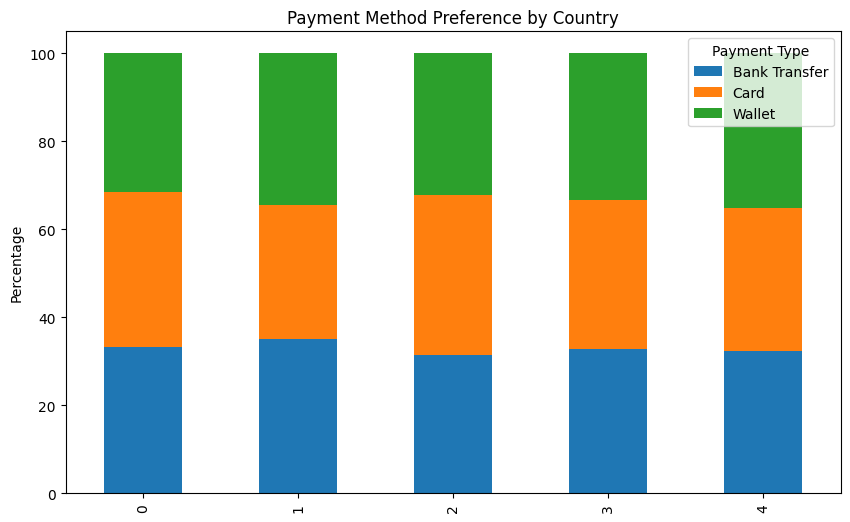

In [114]:
country_payment_pct_1.plot(kind="bar", stacked=True, figsize=(10,6))
plt.title("Payment Method Preference by Country")
plt.ylabel("Percentage")
plt.legend(title="Payment Type")
plt.show()

In [115]:
# Q32 Relationship between risk score and transaction amount
df[["risk_score", "amount_usd"]].corr()


,risk_score,amount_usd
risk_score,1.000000,0.005841
amount_usd,0.005841,1.000000


C:\Users\zaids\AppData\Local\Temp\ipykernel_37820\1732525337.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("risk_bucket")["is_success"]


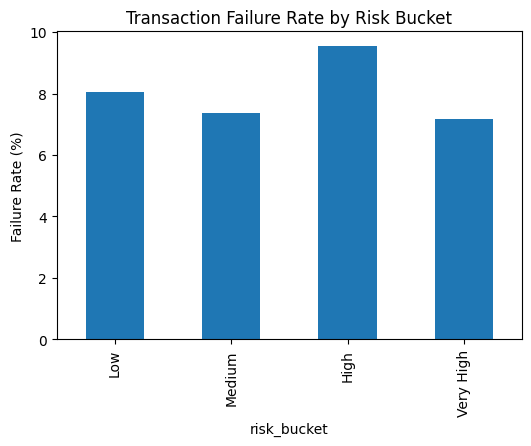

In [116]:
failure_by_risk = (
    df.groupby("risk_bucket")["is_success"]
      .apply(lambda x: (1 - x.mean()) * 100)
)

failure_by_risk.plot(kind="bar", figsize=(6,4))
plt.title("Transaction Failure Rate by Risk Bucket")
plt.ylabel("Failure Rate (%)")
plt.show()


C:\Users\zaids\AppData\Local\Temp\ipykernel_37820\1565092897.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  failure_by_risk_1 = 1 - df.groupby("risk_bucket")["is_success"].mean()


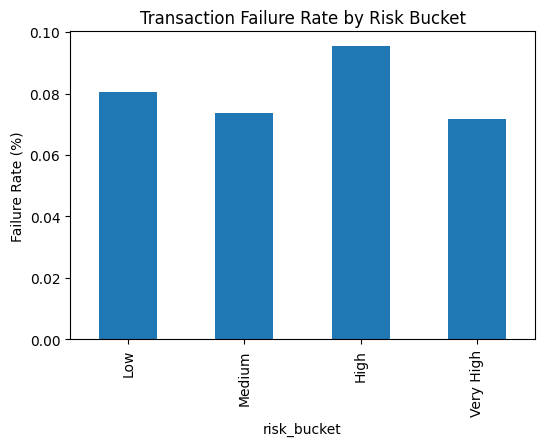

In [117]:
failure_by_risk_1 = 1 - df.groupby("risk_bucket")["is_success"].mean()
    
failure_by_risk_1.plot(kind="bar", figsize=(6,4))
plt.title("Transaction Failure Rate by Risk Bucket")
plt.ylabel("Failure Rate (%)")
plt.show()

In [118]:
# Q33 What % of transaction volume has FX applied vs non-FX?

fx_volume_pct = df["fx_applied"].value_counts(normalize=True) * 100
fx_volume_pct

fx_applied
Yes    74.966443
No     25.033557
Name: proportion, dtype: float64

In [119]:
# Q34 What is the total estimated FX revenue?
print(df["fx_revenue"].sum())

5561.226895


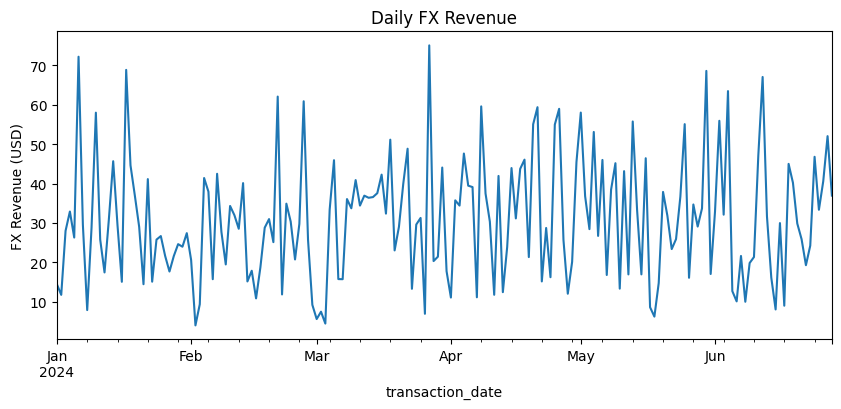

In [120]:
# Q35 FX Revenue Trend Over Time

daily_fx = df.groupby("transaction_date")["fx_revenue"].sum().sort_index()

daily_fx.plot(figsize=(10,4))
plt.title("Daily FX Revenue")
plt.ylabel("FX Revenue (USD)")
plt.show()

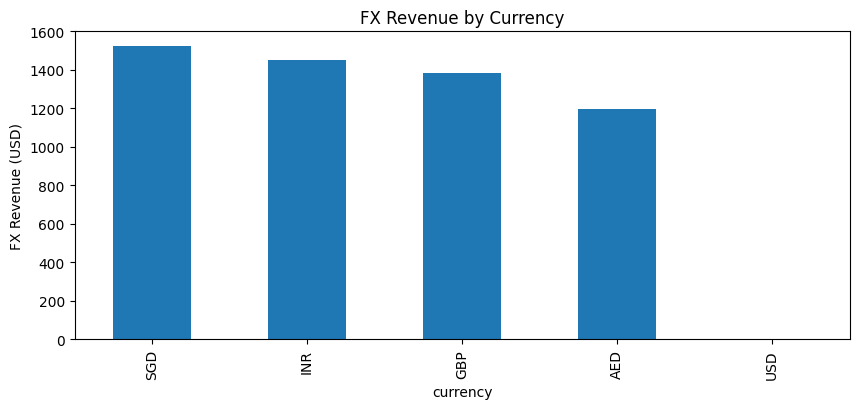

In [121]:
# Q35 FX Revenue by Currency
currency_fx = df.groupby("currency")["fx_revenue"].sum().sort_values(ascending=False)
currency_fx.plot(kind="bar", figsize=(10,4))
plt.title("FX Revenue by Currency")
plt.ylabel("FX Revenue (USD)")
plt.show()

In [123]:
# Q36 Weighted Average FX Margin

weighted_fx_margin = (
    (df["amount_usd"] * df["fx_margin_pct"]).sum()
    / df["amount_usd"].sum()
)

print(f"Weighted Average FX Margin: {weighted_fx_margin:.2f}%")

Weighted Average FX Margin: 1.29%


In [124]:
# Q37 FX Revenue Per Customer

fx_per_customer = (
    df.groupby("customer_id")["fx_revenue"]
      .sum()
)

fx_per_customer.describe()

count    499.000000
mean      11.144743
std        8.399871
min        0.000000
25%        4.870167
50%        9.195289
75%       15.448149
max       45.003203
Name: fx_revenue, dtype: float64

In [125]:
# Q38 Countries Most Dependent on FX Revenue

country_fx_dependency = (
    df.groupby("country")[["amount_usd", "fx_revenue"]]
      .sum()
)

country_fx_dependency["fx_dependency_pct"] = (
    country_fx_dependency["fx_revenue"] / country_fx_dependency["amount_usd"] * 100


)

country_fx_dependency.sort_values("fx_dependency_pct", ascending=False)[
    ["fx_dependency_pct"]]

,fx_dependency_pct
country,
Singapore,1.056480
USA,1.042917
UAE,0.955098
UK,0.924568
India,0.903394


In [126]:
# Q39 % of Total Revenue from FX
total_revenue = df["amount_usd"].sum()
total_fx_revenue = df["fx_revenue"].sum()
percentage_fx_revenue = (total_fx_revenue / total_revenue * 100) if total_revenue > 0 else 0
percentage_fx_revenue

np.float64(0.9760788807701682)

In [127]:
# Q40 Margin Sensitivity Analysis (±0.5%)

# Create a new column with adjusted margins (±0.5%)
df["fx_revenue_plus_0_5"] = np.where(
    df["fx_applied"] == "Yes",
    df["amount_usd"] * ((df["fx_margin_pct"] + 0.5) / 100),
    0
)

df["fx_revenue_minus_0_5"] = np.where(
    df["fx_applied"] == "Yes",
    df["amount_usd"] * ((df["fx_margin_pct"] - 0.5) / 100),
    0
)

sensitivity_analysis = {
    "Current FX Revenue": df["fx_revenue"].sum(),
    "FX Revenue (+0.5%)": df["fx_revenue_plus_0_5"].sum(),
    "FX Revenue (-0.5%)": df["fx_revenue_minus_0_5"].sum()
}

sensitivity_analysis

print(f"the current total FX revenue is ${sensitivity_analysis['Current FX Revenue']:.2f}.")
print(f"If the FX margin increases by 0.5 percentage points, the total FX revenue would increase to ${sensitivity_analysis['FX Revenue (+0.5%)']:.2f}.")
print(f"If the FX margin decreases by 0.5 percentage points, the total FX revenue would decrease to ${sensitivity_analysis['FX Revenue (-0.5%)']:.2f}.")

the current total FX revenue is $5561.23.
If the FX margin increases by 0.5 percentage points, the total FX revenue would increase to $7691.18.
If the FX margin decreases by 0.5 percentage points, the total FX revenue would decrease to $3431.27.


In [128]:
# Q41 Potential FX Revenue Leakage

leakage = df[
    (df["fx_applied"] == "Yes") &
    (df["fx_margin_pct"].isnull())
]

len(leakage)

0

In [129]:
# Q42 Most Profitable Customer Segment

segment_profitability = (
    df.groupby(["customer_type", "risk_bucket"])["fx_revenue"]
      .sum()
      .sort_values(ascending=False)
)

segment_profitability

C:\Users\zaids\AppData\Local\Temp\ipykernel_37820\544804164.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["customer_type", "risk_bucket"])["fx_revenue"]


customer_type  risk_bucket
Individual     High           1037.702493
               Low             999.677120
               Medium          998.122954
               Very High       984.676376
Business       Very High       420.375250
               High            419.980267
               Medium          365.209995
               Low             335.482438
Name: fx_revenue, dtype: float64

In [130]:
# Q43 Risk Segments to Deprioritize

risk_profit = df.groupby("risk_bucket")["fx_revenue"].sum()
risk_profit

C:\Users\zaids\AppData\Local\Temp\ipykernel_37820\4124387642.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  risk_profit = df.groupby("risk_bucket")["fx_revenue"].sum()


risk_bucket
Low          1335.159558
Medium       1363.332950
High         1457.682760
Very High    1405.051626
Name: fx_revenue, dtype: float64

In [131]:
# Q44 Where Can FX Revenue Be Increased?

df.groupby("payment_type")["fx_revenue"].sum()

payment_type
Bank Transfer    1897.268581
Card             1821.627034
Wallet           1842.331280
Name: fx_revenue, dtype: float64

In [132]:
# Q45 What Drives Failed Transactions?

df.groupby("risk_bucket")["is_success"].mean() * 100

C:\Users\zaids\AppData\Local\Temp\ipykernel_37820\628496692.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("risk_bucket")["is_success"].mean() * 100


risk_bucket
Low          91.941876
Medium       92.647059
High         90.457516
Very High    92.816901
Name: is_success, dtype: float64

In [133]:
df.groupby("payment_type")["is_success"].mean() * 100


payment_type
Bank Transfer    91.065990
Card             93.413174
Wallet           91.339376
Name: is_success, dtype: float64

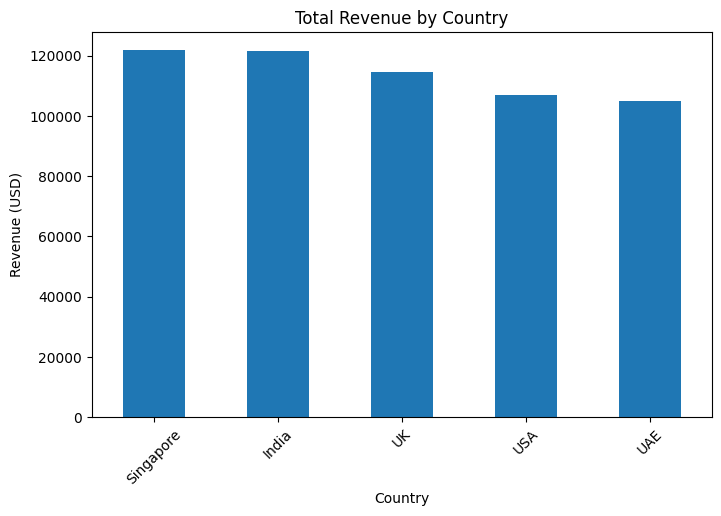

In [134]:
country_revenue = (
    df.groupby("country")["amount_usd"]
      .sum()
      .sort_values(ascending=False)
)

country_revenue.plot(kind="bar", figsize=(8,5))
plt.title("Total Revenue by Country")
plt.ylabel("Revenue (USD)")
plt.xlabel("Country")
plt.xticks(rotation=45)
plt.show()

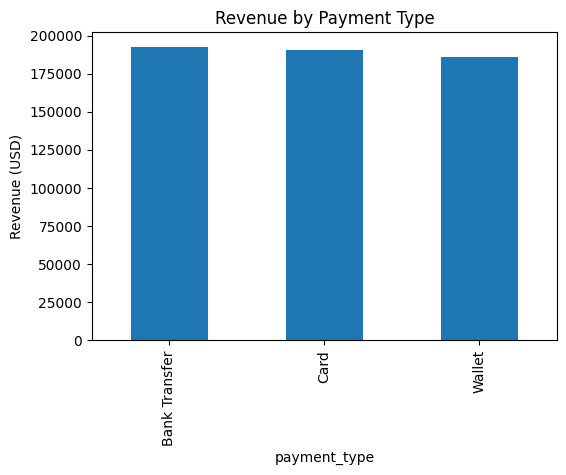

In [135]:
payment_revenue = df.groupby("payment_type")["amount_usd"].sum()

payment_revenue.plot(kind="bar", figsize=(6,4))
plt.title("Revenue by Payment Type")
plt.ylabel("Revenue (USD)")
plt.show()


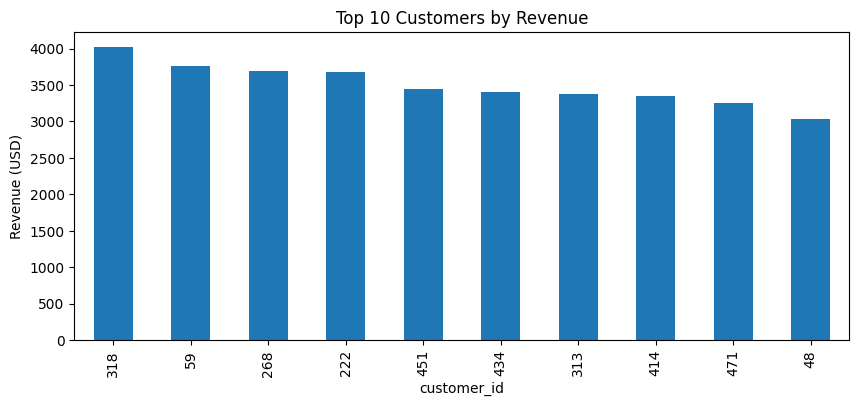

In [136]:
top10 = (
    df.groupby("customer_id")["amount_usd"]
      .sum()
      .sort_values(ascending=False)
      .head(10)
)

top10.plot(kind="bar", figsize=(10,4))
plt.title("Top 10 Customers by Revenue")
plt.ylabel("Revenue (USD)")
plt.show()

C:\Users\zaids\AppData\Local\Temp\ipykernel_37820\2624379690.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  risk_revenue = df.groupby("risk_bucket")["amount_usd"].sum()


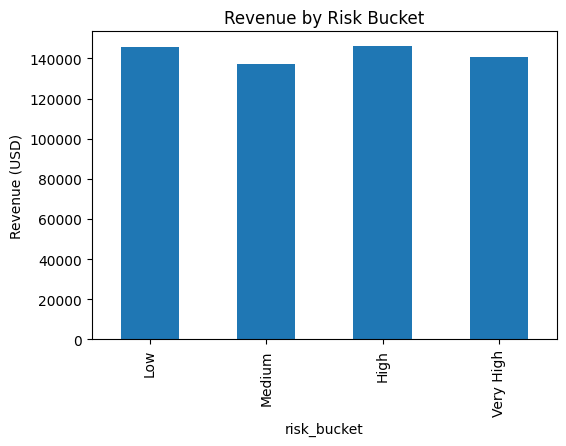

In [137]:
risk_revenue = df.groupby("risk_bucket")["amount_usd"].sum()

risk_revenue.plot(kind="bar", figsize=(6,4))
plt.title("Revenue by Risk Bucket")
plt.ylabel("Revenue (USD)")
plt.show()


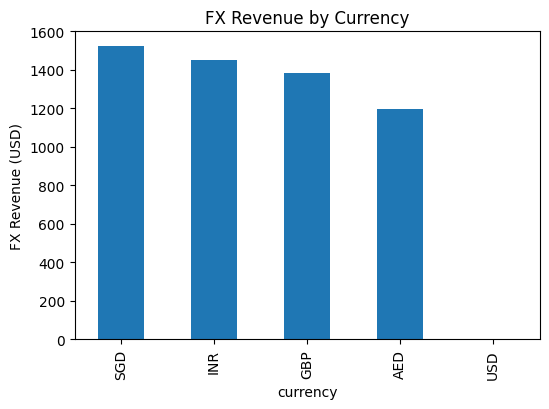

In [138]:
fx_currency = (
    df.groupby("currency")["fx_revenue"]
      .sum()
      .sort_values(ascending=False)
)

fx_currency.plot(kind="bar", figsize=(6,4))
plt.title("FX Revenue by Currency")
plt.ylabel("FX Revenue (USD)")
plt.show()


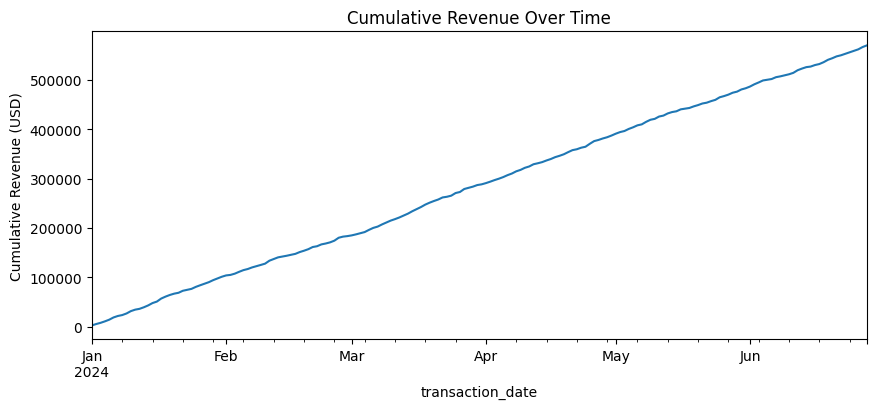

In [139]:
daily_revenue = (
    df.groupby("transaction_date")["amount_usd"]
      .sum()
      .sort_index()
)

cumulative_revenue = daily_revenue.cumsum()

cumulative_revenue.plot(figsize=(10,4))
plt.title("Cumulative Revenue Over Time")
plt.ylabel("Cumulative Revenue (USD)")
plt.show()


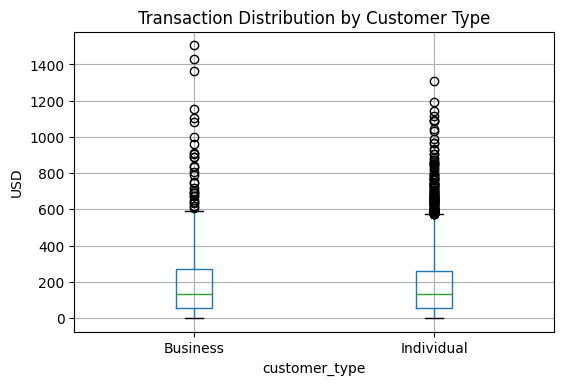

In [140]:
df.boxplot(column="amount_usd", by="customer_type", figsize=(6,4))
plt.title("Transaction Distribution by Customer Type")
plt.suptitle("")
plt.ylabel("USD")
plt.show()


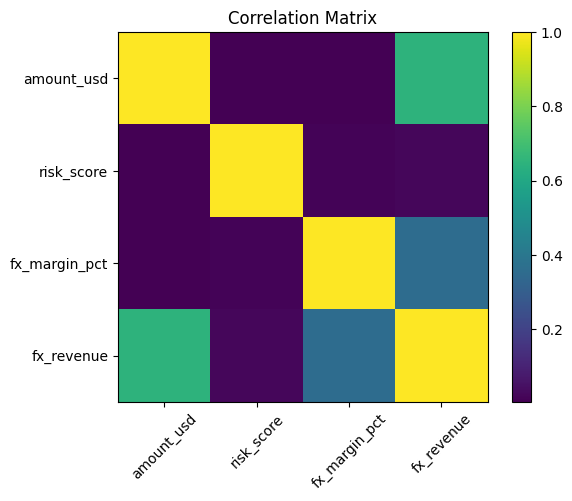

In [141]:
numeric_cols = df[["amount_usd", "risk_score", "fx_margin_pct", "fx_revenue"]]

corr = numeric_cols.corr()

plt.imshow(corr) # Visualize the correlation matrix using a heatmap
plt.xticks(range(len(corr)), corr.columns, rotation=45) # Set x-ticks to column names with rotation for better readability
plt.yticks(range(len(corr)), corr.columns)
plt.colorbar()
plt.title("Correlation Matrix")
plt.show()



# 6️⃣ Executive Summary

This 45-question case study demonstrates:

- Strong EDA & data cleaning
- Multi-table data modeling
- Customer segmentation
- Risk analysis
- FX margin computation
- Financial sensitivity modeling
- Business insight generation

This mirrors real-world fintech analytics workflows.
